## ***MIMIC data***
_Data source: NOTEEVENTS.csv.gz [https://physionet.org/content/mimiciii/1.4/NOTEEVENTS.csv.gz](https://physionet.org/content/mimiciii/1.4/NOTEEVENTS.csv.gz)_

_Creating fine-tuning data for Bio-Clinical BERT Classifier for Kinetic Accident Classification, using only ''History of Present Illness'' from $\texttt{TEXT}$_

##### Model name: **Bio-Clinical BERT Classifier**
##### Research Co-Supervisor / Contributing Author: Dr. Jim Basilakis (Domain Expert / Kinetic-Injury Regex Developer)
##### Author: Midhun Shyam




#### Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re
import numpy as np
import os

## 1. Data exploration

In [ ]:
data = pd.read_csv("NOTEEVENTS.csv.gz", low_memory = False)

In [ ]:
print(data.info(),"\n")
print("Data head:", "\n" ,data.head(2), "\n")
print("ROW_ID is unique:", data["ROW_ID"].is_unique)
print("TEXT is unique:", data["TEXT"].is_unique)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2083180 entries, 0 to 2083179
Data columns (total 11 columns):
 #   Column       Dtype  
---  ------       -----  
 0   ROW_ID       int64  
 1   SUBJECT_ID   int64  
 2   HADM_ID      float64
 3   CHARTDATE    object 
 4   CHARTTIME    object 
 5   STORETIME    object 
 6   CATEGORY     object 
 7   DESCRIPTION  object 
 8   CGID         float64
 9   ISERROR      float64
 10  TEXT         object 
dtypes: float64(3), int64(2), object(6)
memory usage: 174.8+ MB
None 

Data head: 
    ROW_ID  SUBJECT_ID   HADM_ID   CHARTDATE CHARTTIME STORETIME  \
0     174       22532  167853.0  2151-08-04       NaN       NaN   
1     175       13702  107527.0  2118-06-14       NaN       NaN   

            CATEGORY DESCRIPTION  CGID  ISERROR  \
0  Discharge summary      Report   NaN      NaN   
1  Discharge summary      Report   NaN      NaN   

                                                TEXT  
0  Admission Date:  [**2151-7-16**]       Dischar...  

In [ ]:
data = data[["ROW_ID" ,"HADM_ID", "TEXT"]]
data = data.drop_duplicates(subset="TEXT", keep="first")
print("Number of rows:" , data.shape[0])
print("TEXT is unique:", data["TEXT"].is_unique)

Number of rows: 2023185
TEXT is unique: True


In [ ]:
# Calculate the number of words in the TEXT column
data['W_COUNT'] = data['TEXT'].apply(lambda x: len(str(x).split()))

Maximum number of words: 7980
Minimum number of words: 0
Average number of words: 248.73 



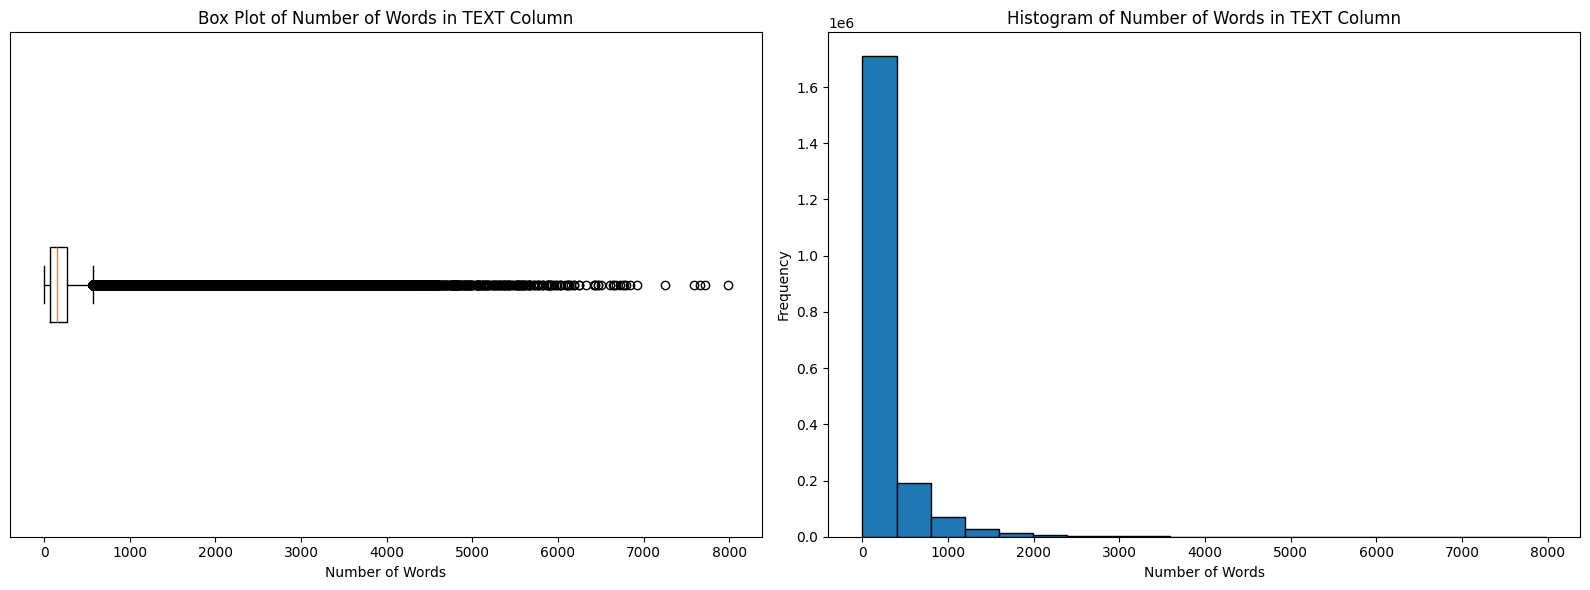

In [ ]:
# Calculate statistics
max_words = data['W_COUNT'].max()
min_words = data['W_COUNT'].min()
avg_words = data['W_COUNT'].mean()

# Print statistics
print(f"Maximum number of words: {max_words}")
print(f"Minimum number of words: {min_words}")
print(f"Average number of words: {avg_words:.2f}", "\n")

fig, ax = plt.subplots(1, 2, figsize=(16, 6))  # Plotting parameters

# Box plot
ax[0].boxplot(data['W_COUNT'], vert=False)
ax[0].set_title('Box Plot of Number of Words in TEXT Column')
ax[0].set_xlabel('Number of Words')
ax[0].set_yticks([])

# Histogram
ax[1].hist(data['W_COUNT'], bins=20, edgecolor='black')
ax[1].set_title('Histogram of Number of Words in TEXT Column')
ax[1].set_xlabel('Number of Words')
ax[1].set_ylabel('Frequency')

# Plot
plt.tight_layout()
plt.show()

In [ ]:
data = data[data["W_COUNT"] > 1]
print("Number of observations having word count less than or equal 512:",data[data["W_COUNT"] <= 512].shape[0])
print("Number of observations having word count more than 512:", data[data["W_COUNT"] > 512].shape[0])

Number of observations having word count less than or equal 512: 1794767
Number of observations having word count more than 512: 228312


In [ ]:
print(f"\n\nDescriptive statistics for NOTEEVENTS:")
print(data["W_COUNT"].describe())



Descriptive statistics for NOTEEVENTS:
count    2.023079e+06
mean     2.487475e+02
std      3.439367e+02
min      2.000000e+00
25%      6.900000e+01
50%      1.460000e+02
75%      2.680000e+02
max      7.980000e+03
Name: W_COUNT, dtype: float64


In [ ]:
# --- Heading counter function ---
def count_headings(dataframe, column_name='TEXT'):
    heading_counter = Counter()

    # Regular expression pattern to identify headings that end with a colon
    pattern = re.compile(r'\b[A-Za-z ]+?:')

    # Iterate through each row in the dataframe
    for text in dataframe[column_name].dropna():  # Dropping NaN values to ensure all entries are strings
        if isinstance(text, str):  # Ensure that the text is a string
            # Extract all headings using the regex pattern
            found_headings = pattern.findall(text)
            # Normalize and count each heading
            for heading in found_headings:
                normalized_heading = heading.strip()
                heading_counter[normalized_heading] += 1

    return heading_counter

In [ ]:
headings = count_headings(data, column_name='TEXT')

In [ ]:
# Print only headings appearing more than 12000 times, sorted by count in descending order
sorted_headings = sorted(headings.items(), key=lambda item: item[1], reverse=True)
for heading, count in sorted_headings:
    if count > 12000:
        print(f"{heading} {count}")

Reason: 629952
Plan: 527309
MEDICAL CONDITION: 499198
REASON FOR THIS EXAMINATION: 498823
Assessment: 457012
Response: 450494
Action: 448915
IMPRESSION: 443401
Admitting Diagnosis: 386765
Comments: 307366
P: 288818
INDICATION: 245672
FINDINGS: 241460
A: 213649
COMPARISON: 185148
mg Tablet Sig: 182426
CV: 179921
Allergies: 177061
Nutrition: 159282
Drains: 155895
HISTORY: 154075
Contrast: 151764
O: 151252
Communication: 144296
BP: 142137
Prophylaxis: 140187
Chief Complaint: 139758
HR: 139240
GU: 139207
GI: 138461
RR: 137813
Heart rhythm: 137692
Code status: 135381
Balance: 133701
Other labs: 132363
Height: 131211
Urine: 131082
Stool: 130475
PO: 130425
Total out: 130416
Total In: 130408
NG: 130244
Blood products: 130185
Other ICU medications: 129564
Last dose of Antibiotics: 129465
Infusions: 128993
TECHNIQUE: 128268
Tmax: 128151
ABG: 127869
Other medications: 126843
DVT: 126766
Stress ulcer: 125564
Lines: 125198
Glycemic Control: 124325
Skin: 123569
Neurologic: 122479
Delivery Device: 12

## 2. Data preprocessing

In [ ]:
pdata = data.copy() # -To avoid warnings

### 2.1 Text extraction

In [ ]:
# --- Define target heading variations ---
heading_variations = {
    # 'Admit Diagnosis': [
    #     'Admit diagnosis',
    #     'Admitting Diagnosis',
    #     'ADMIT DIAGNOSIS'
    # ],
    # 'Medical Condition': [
    #     'MEDICAL CONDITION',
    #     'Medical Condition'
    # ],
    'History of Present Illness': [
        'History of Present Illness',
    #     'HISTORY OF PRESENT ILLNESS',
    #     'HISTORY OF THE PRESENT ILLNESS',
    #     'History of the present illness',
    #     'HPI'
    ],
    # 'Chief Complaint': [
    #     'Chief Complaint',
    #     'chief complaint',
    #     'CHIEF COMPLAINT'
    # ]
}

# Create a mapping from lowercase variants to standardized headings.
variation_to_standard = {}
for standard, variations in heading_variations.items():
    for variant in variations:
        variation_to_standard[variant.lower()] = standard

# --- Build the regex pattern using only the target headings ---
# Escape each variant and sort by length (longer ones first to avoid partial matches)
escaped_headings = sorted(
    [re.escape(variant) for variant in variation_to_standard.keys()],
    key=len,
    reverse=True
)
headings_pattern = '|'.join(escaped_headings)

# The regex stops capturing when it sees a newline followed by a line that starts with some text and a colon.
pattern = re.compile(
    rf'(?P<heading>{headings_pattern})\s*:\s*'
    rf'(?P<content>.*?)(?=\n\s*[^:\n]+:\s*|\Z)',
    re.IGNORECASE | re.DOTALL
)

In [ ]:
# --- Extraction Function ---
def extract_headings(text, pattern, variation_mapping):
    """
    For each target heading in text, capture its content.
    For headings known to be one-line (such as Admitting Diagnosis), only the first line is kept.
    Also, if the captured content is empty or its first nonempty line looks like another heading,
    the value is set to None.
    """
    matches = pattern.finditer(text)
    extracted = {}
    for match in matches:
        heading_variant = match.group('heading').strip().lower()
        content = match.group('content')  # may be multiline
        content_stripped = content.strip() if content else ''

        # Check if the first nonempty line itself looks like a heading (e.g., "24 Hour Events:")
        first_non_empty_line = None
        for line in content.splitlines():
            if line.strip():
                first_non_empty_line = line.strip()
                break
        if first_non_empty_line and re.match(r'^[^:]+:\s*$', first_non_empty_line):
            content_stripped = ''
        if not content_stripped:
            content_stripped = None

        standard_heading = variation_mapping.get(heading_variant)
        if standard_heading:
            # Special rule: for headings expected to be one line (e.g., Admitting Diagnosis),
            # take only the first line.
            if standard_heading == "Admit Diagnosis":
                first_line = content.splitlines()[0].strip() if content else ""
                content_stripped = first_line if first_line else None

            # Merge content if the heading appears more than once.
            if standard_heading in extracted:
                if extracted[standard_heading] is None:
                    extracted[standard_heading] = content_stripped
                else:
                    if content_stripped is not None:
                        extracted[standard_heading] += " " + content_stripped
            else:
                extracted[standard_heading] = content_stripped
    return extracted

In [ ]:
extract = pdata['TEXT'].apply(lambda x: extract_headings(x, pattern, variation_to_standard))
extract = pd.json_normalize(extract)
pdata = pdata.join(extract)
print(pdata.head(3))

   ROW_ID   HADM_ID                                               TEXT  \
0     174  167853.0  Admission Date:  [**2151-7-16**]       Dischar...   
1     175  107527.0  Admission Date:  [**2118-6-2**]       Discharg...   
2     176  167118.0  Admission Date:  [**2119-5-4**]              D...   

   W_COUNT                         History of Present Illness  
0      110                                                NaN  
1     1943  This is an 81-year-old female\nwith a history ...  
2     1426  This 81 year old woman has a history of COPD. ...  


In [ ]:
# Create the new df - clinicalnotes(cnotes) with the text columns containing History of Present Illness
cnotes = pdata[['ROW_ID','HADM_ID', 'TEXT', 'History of Present Illness']]
print(cnotes.head(3), "\n")
print("History of Present Illness is unique:", cnotes['History of Present Illness'].is_unique)
print("History of Present Illness ROW_ID is unique:", cnotes['History of Present Illness'].is_unique)

   ROW_ID   HADM_ID                                               TEXT  \
0     174  167853.0  Admission Date:  [**2151-7-16**]       Dischar...   
1     175  107527.0  Admission Date:  [**2118-6-2**]       Discharg...   
2     176  167118.0  Admission Date:  [**2119-5-4**]              D...   

                          History of Present Illness  
0                                                NaN  
1  This is an 81-year-old female\nwith a history ...  
2  This 81 year old woman has a history of COPD. ...   

History of Present Illness is unique: False
History of Present Illness ROW_ID is unique: False


In [ ]:
# Remove duplicates and null observations
cnotes = cnotes.drop_duplicates(subset="History of Present Illness", keep="first")
cnotes = cnotes.dropna(subset=['History of Present Illness'])
print("History of Present Illness ROW_ID is unique:", cnotes['ROW_ID'].is_unique)
print("History of Present Illness is unique:", cnotes['History of Present Illness'].is_unique)
print("Number of History of Present Illness observations:", cnotes.shape[0])

History of Present Illness ROW_ID is unique: True
History of Present Illness is unique: True
Number of History of Present Illness observations: 50694


### 2.2 Data cleaning

In [ ]:
# --- Cleaner Function ---
class TextCleaner:
    def __init__(self):
        # Regex to match patterns like [** ... **], (** ... **), or ** ... **
        # Use a lazy quantifier (.*?) and DOTALL so we match across newlines or unusual characters.
        self.pattern = re.compile(
            r'\[\*\*.*?\*\*\]|\(\*\*.*?\*\*\)|\*\*.*?\*\*',
            flags=re.DOTALL
        )

    def remove_encodings(self, text):
        """Remove specific encoded patterns from the text."""
        return re.sub(self.pattern, '', text).strip()

    def clean_text(self, text):
        """General purpose text cleaning function, removing various patterns."""
        # 1. Remove the encoded patterns first
        text = self.remove_encodings(text)

        # 2. Remove any leftover sequences of asterisks (e.g., '****')
        text = re.sub(r'\*+', ' ', text)

        # 3. Replace multiple underscores with a single space
        text = re.sub(r'__+', ' ', text)

        # 4. Normalize whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        # 5. Remove dates of the form YYYY-MM-DD
        text = re.sub(r'\d{4}-\d{1,2}-\d{1,2}', '', text)

        # 6. Remove brackets
        text = re.sub(r'[\(\)\[\]{}]', '', text)

        # 7. Remove punctuation (semicolon, colon, comma, dot, and question mark)
        # text = re.sub(r'[;,\.\?]', '', text)

        return text

    def apply_cleaning(self, dataframe, column_name='TEXT'):
        """Apply cleaning function to a DataFrame column."""
        CLEAN_TEXT = dataframe[column_name].apply(self.clean_text)
        dataframe = dataframe.assign(CLEAN_TEXT=CLEAN_TEXT)
        return dataframe

In [ ]:
cleaner = TextCleaner()
cnotes = cleaner.apply_cleaning(dataframe = cnotes, column_name = "History of Present Illness")
print("CLEAN_TEXT is unique:", cnotes['CLEAN_TEXT'].is_unique)

CLEAN_TEXT is unique: False


In [ ]:
cnotes = cnotes.drop_duplicates(subset="CLEAN_TEXT", keep="first")
print("CLEAN_TEXT is unique:", cnotes['CLEAN_TEXT'].is_unique)

CLEAN_TEXT is unique: True


In [ ]:
text = cnotes.copy().drop(columns = {"TEXT", "History of Present Illness"})
text = text.rename(columns = {"CLEAN_TEXT": "TEXT"})

In [ ]:
# Count the number of words
text['W_COUNT'] = text['TEXT'].apply(lambda x: len(str(x).split()))

In [ ]:
# --- Duplicate sentence remover function ---
def remove_duplicate_sentences(text):
    # Use regex to split text into sentences; this handles common punctuation.
    sentences = re.split(r'(?<=[.!?]) +', text)
    seen = set()
    unique_sentences = []
    for sentence in sentences:
        if sentence not in seen:
            seen.add(sentence)
            unique_sentences.append(sentence)
    return " ".join(unique_sentences)


text["TEXT"] = text["TEXT"].apply(remove_duplicate_sentences)
print("Number of observations having word count more than 512:", text[text["W_COUNT"] > 512].shape[0])

Number of observations having word count more than 512: 350


In [ ]:
# --- Truncate function ---
def truncate_text_to_512(text):
    # Ensure that text is a string
    if not isinstance(text, str):
        return text
    words = text.split()
    truncated = " ".join(words[:512])
    return truncated

# Truncate input to 512 words for Bio_ClinicalBERT to match its maximum input length.
text["TEXT"] = text["TEXT"].apply(truncate_text_to_512)

# Update word count
text['W_COUNT'] = text['TEXT'].apply(lambda x: len(str(x).split()))
text = text[text["W_COUNT"] > 1]

Maximum number of words: 512
Minimum number of words: 2
Average number of words: 150.55 



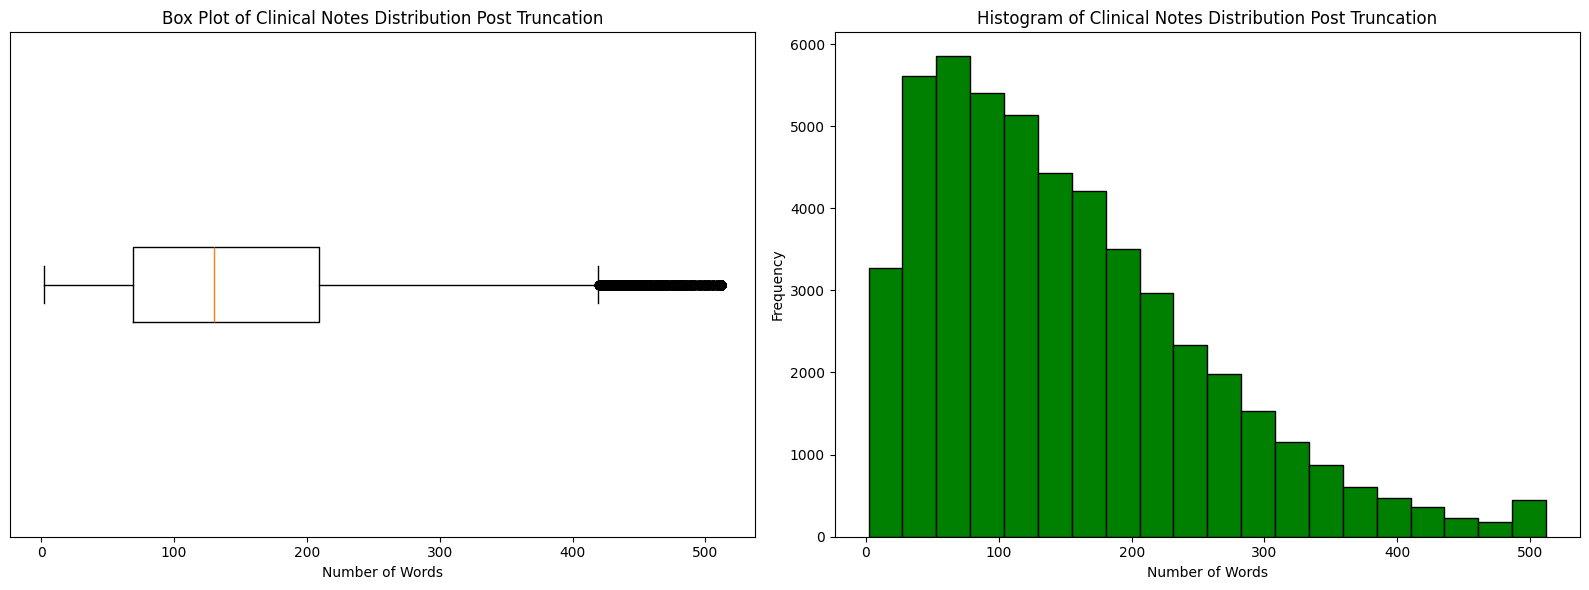

In [ ]:
# Calculate statistics
max_words = text['W_COUNT'].max()
min_words = text['W_COUNT'].min()
avg_words = text['W_COUNT'].mean()

# Print statistics
print(f"Maximum number of words: {max_words}")
print(f"Minimum number of words: {min_words}")
print(f"Average number of words: {avg_words:.2f}", "\n")

# Set the figure and plots
fig, ax = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Box plot on the first subplot
ax[0].boxplot(text['W_COUNT'], vert=False)
ax[0].set_title('Box Plot of Clinical Notes Distribution Post Truncation')
ax[0].set_xlabel('Number of Words')
ax[0].set_yticks([])  # Hide y-axis ticks

# Histogram on the second subplot
ax[1].hist(text['W_COUNT'], bins=20, edgecolor='black', color='green')
ax[1].set_title('Histogram of Clinical Notes Distribution Post Truncation')
ax[1].set_xlabel('Number of Words')
ax[1].set_ylabel('Frequency')

# Adjust layout to prevent overlap and plot
plt.tight_layout()
plt.show()

In [ ]:
# text.to_csv("clinical_text.csv", index = False)

#### This extracted dataset is called "***cleaned $\texttt{NOTEEVENTS}$***"

## 3. Label Annotation using Dr. Jim Basilakis's (Domain Expert) Kinetic Trauma Regular-Expression

In [ ]:
# text = pd.read_csv("clinical_text.csv")

In [ ]:
# --- Dr. Jim's (Domain Expert) vehicle regex ---
KTInj_regex = (
    r'\b(?:mva|mba|vehicle|bus|pedestrian|atv|passenger|ute|ped|bike|dirtbike|motorbike|pushbike|scooter|truck|'
    r'bicycle|motorcycle|driver|driving|rtc|rta|\d*km[a-zA-Z/]*|skateboard|surfing|surf|horse|collision|'
    r'crossing|buggy|ebike|jetski|vs car|car vs|car accident|moving car|traffic light|traffic lights|'
    r'hit by car|hit by a car|car hit|airbag|tyre|airbags|T boned)\b'
)

# Compile the regex with case-insensitive flag.
pattern = re.compile(KTInj_regex, re.IGNORECASE)

In [ ]:
# --- Prediction function using the regex ---
def predict_ka(text):
    """
    Given a text string, return a tuple (label, responsible_keywords) where:
      - label is True if any vehicle-related keyword is found, else False.
      - responsible_keywords is a comma-separated string of the matched keywords in lower case (or None if no match).
    """
    # Find all matching keywords in the text.
    matches = pattern.findall(text)
    if matches:
        # Convert each match to lower case and remove duplicates by converting to a set.
        unique_matches = list(set(match.lower() for match in matches))
        # Sort the keywords.
        unique_matches.sort()
        return True, ", ".join(unique_matches)
    else:
        return False, None

In [ ]:
# Predict the labels
text[['REGEX_LABEL', 'KEY']] = text['TEXT'].apply(lambda x: pd.Series(predict_ka(x)))

In [ ]:
# Subset the true cases
true = text[text["REGEX_LABEL"] == True]
true = true.sort_values(by='KEY')
print(true.head(3),"\n")
print("Total no of rows:", true.shape[0])

       ROW_ID   HADM_ID                                               TEXT  \
28232   25650  168808.0  Patient is 17 year old male brought in by afte...   
33303   27066  191454.0  54 yo M, Pt has long h/o EtOH cirrhossis s/p T...   
34653   30114  110068.0  22YO s/p unrestrained MVC. According to pt's f...   

       W_COUNT  REGEX_LABEL     KEY  
28232       41         True  airbag  
33303       90         True  airbag  
34653       39         True  airbag   

Total no of rows: 2034


In [ ]:
# true.to_csv("true.csv", index = False)

In [ ]:
# Subset the false cases
false = text[text["REGEX_LABEL"] == False]
print(false.head(3),"\n")
print("Total no of rows:", false.shape[0])

   ROW_ID   HADM_ID                                               TEXT  \
1     175  107527.0  This is an 81-year-old female with a history o...   
2     176  167118.0  This 81 year old woman has a history of COPD. ...   
3     177  196489.0  87 yo F with h/o CHF, COPD on 5 L oxygen at ba...   

   W_COUNT  REGEX_LABEL   KEY  
1      115        False  None  
2      244        False  None  
3      265        False  None   

Total no of rows: 48512


In [ ]:
# false.to_csv("false.csv", index = False)

## 4. Create the training set
#### The cases identified by regex were manually annotated, and domain-specific keywords were evaluated by human reviewers. This process helped identify edge cases and misclassifications, which were used to test the model’s performance.

In [19]:
gs_true = pd.read_csv("gs_true.csv")
false = pd.read_csv("false.csv")

In [18]:
print(gs_true.head(2), "\n")
print("Distribution of human annotated labels:","\n",gs_true["LABEL"].value_counts())

     ROW_ID                                               TEXT  LABEL
407     134  Mr.  is an 84 year old gentleman with a PMH si...    0.0
408     133  83-year-old male who underwent coronary artery...    0.0 

Distribution of human annotated labels: 
 LABEL
1.0    1309
0.0     725
Name: count, dtype: int64


In [ ]:
gs_true = gs_true.drop_duplicates(subset="TEXT", keep="first")

A total of 725 misclassifications including edge cases were identified through human evaluation

In [39]:
# False Observation Sampling

# Required false sample count is the difference between human annotated labels.
reqfalse = 1309 - 725

# Step 1: Create bins from gs_true using pd.qcut and retrieve the bin edges.
num_bins = 10
gs_true['w_bin'], bins = pd.qcut(gs_true['W_COUNT'], q=num_bins, duplicates='drop', retbins=True)

# Apply the same bins to false using pd.cut.
false['w_bin'] = pd.cut(false['W_COUNT'], bins=bins, include_lowest=True)

# Step 2: Get the counts (and proportions) per bin from gs_true.
true_bin_counts = gs_true['w_bin'].value_counts().sort_index()
total_true = gs_true.shape[0]
true_bin_props = true_bin_counts / total_true

print("gs_true W_COUNT bin distribution:")
print(true_bin_counts)
print("\nProportions per bin:")
print(true_bin_props)

# Step 3: For each bin, determine how many false samples to draw based on the desired total.
sampled_false_list = []
for bin_val, prop in true_bin_props.items():
    desired_count_bin = int(round(reqfalse * prop))
    false_subset = false[false['w_bin'] == bin_val]

    if len(false_subset) < desired_count_bin:
        print(f"Warning: Not enough false cases in bin {bin_val}. Needed {desired_count_bin}, available {len(false_subset)}.")
        sampled = false_subset.copy()  # take all available if fewer
    else:
        sampled = false_subset.sample(n=desired_count_bin, random_state=42)

    sampled_false_list.append(sampled)

# Step 4: Concatenate the sampled false cases and drop the helper column.
false_sampled = pd.concat(sampled_false_list, ignore_index=True)
false_sampled = false_sampled.drop(columns=['w_bin'])
false_sampled = false_sampled.drop_duplicates(subset="TEXT", keep="first")
print("\nSampled false cases head:")
print(false_sampled.head(3))
print("\nTotal number of false samples selected:", false_sampled.shape[0])

gs_true W_COUNT bin distribution:
w_bin
(3.999, 26.0]     220
(26.0, 35.0]      191
(35.0, 44.0]      216
(44.0, 52.0]      200
(52.0, 62.0]      193
(62.0, 73.0]      214
(73.0, 88.0]      199
(88.0, 115.0]     196
(115.0, 182.0]    204
(182.0, 623.0]    201
Name: count, dtype: int64

Proportions per bin:
w_bin
(3.999, 26.0]     0.108161
(26.0, 35.0]      0.093904
(35.0, 44.0]      0.106195
(44.0, 52.0]      0.098328
(52.0, 62.0]      0.094887
(62.0, 73.0]      0.105211
(73.0, 88.0]      0.097837
(88.0, 115.0]     0.096362
(115.0, 182.0]    0.100295
(182.0, 623.0]    0.098820
Name: count, dtype: float64

Sampled false cases head:
   ROW_ID                                               TEXT  W_COUNT  \
0    8946  This is a 42 year old woman with a history of ...       17   
1   34238  39 year old female with h/o headaches and poss...       18   
2   24840  is the former 2.58 kg product of a 35-6/7 week...       16   

   REGEX_LABEL  KEY  
0        False  NaN  
1        False  NaN  
2 

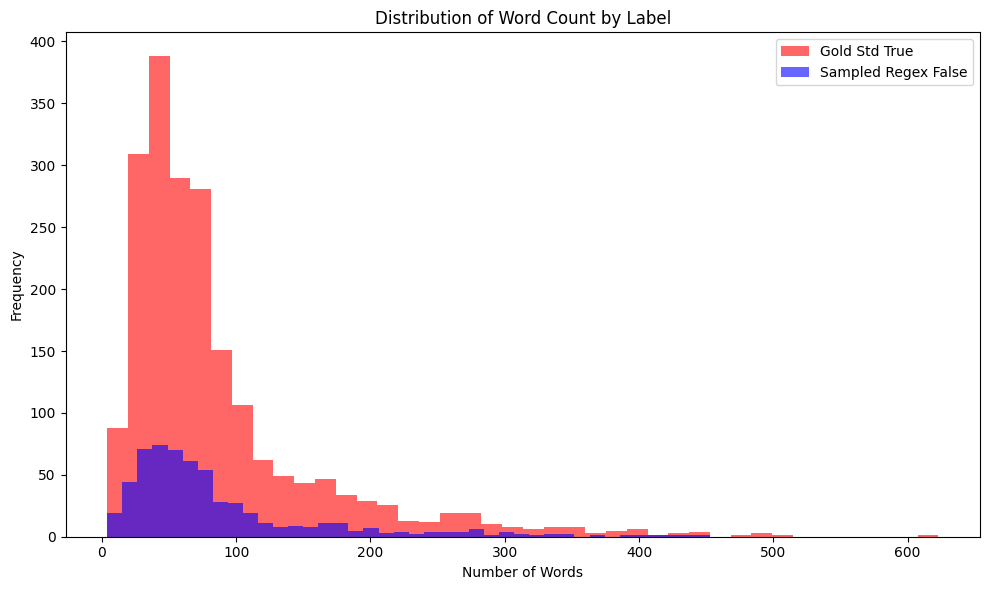

In [40]:
# Plot Gold Std True cases & Sampled Regex False cases

plt.figure(figsize=(10, 6))

plt.hist(gs_true['W_COUNT'],
         bins=40,
         color='red',
         alpha=0.6,
         label='Gold Std True')


plt.hist(false_sampled['W_COUNT'],
         bins=40,
         color='blue',
         alpha=0.6,
         label='Sampled Regex False')

# Labels and title
plt.title('Distribution of Word Count by Label')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

# Legend
plt.legend()

# Show
plt.tight_layout()
plt.show()

In [41]:
# Create the false label
false_sampled["LABEL"] = np.zeros(len(false_sampled))
gs_true.drop(columns = ["w_bin"], inplace = True) # Drop the w_bin

In [42]:
false_sampled["REGEX_LABEL"] = false_sampled["REGEX_LABEL"].astype(int)
print(false_sampled.head(2))

   ROW_ID                                               TEXT  W_COUNT  \
0    8946  This is a 42 year old woman with a history of ...       17   
1   34238  39 year old female with h/o headaches and poss...       18   

   REGEX_LABEL  KEY  LABEL  
0            0  NaN    0.0  
1            0  NaN    0.0  


In [43]:
train = pd.concat([gs_true, false_sampled], ignore_index=True)
train["LABEL"] = train["LABEL"].astype(int)

# Display the first few rows of the train set
print("Train dataset:")
print(train.head(3))
print("\nShape of train dataset:", train.shape)
print("\nClass Counts:\n",train["LABEL"].value_counts())

Train dataset:
   ROW_ID                                               TEXT  LABEL  W_COUNT  \
0     134  Mr.  is an 84 year old gentleman with a PMH si...      0      314   
1     133  83-year-old male who underwent coronary artery...      0       77   
2     132  This 83 year old white male with complaints of...      0       34   

   REGEX_LABEL  KEY  
0          NaN  NaN  
1          NaN  NaN  
2          NaN  NaN  

Shape of train dataset: (2617, 6)

Class Counts:
 LABEL
1    1309
0    1308
Name: count, dtype: int64


In [29]:
train = pd.read_csv("s_train.csv")

The false samples were also manually evaluated, and 176 misclassifications were identified.

In [38]:
print(train['LABEL'].value_counts())

LABEL
1.0    1309
0.0    1132
Name: count, dtype: int64


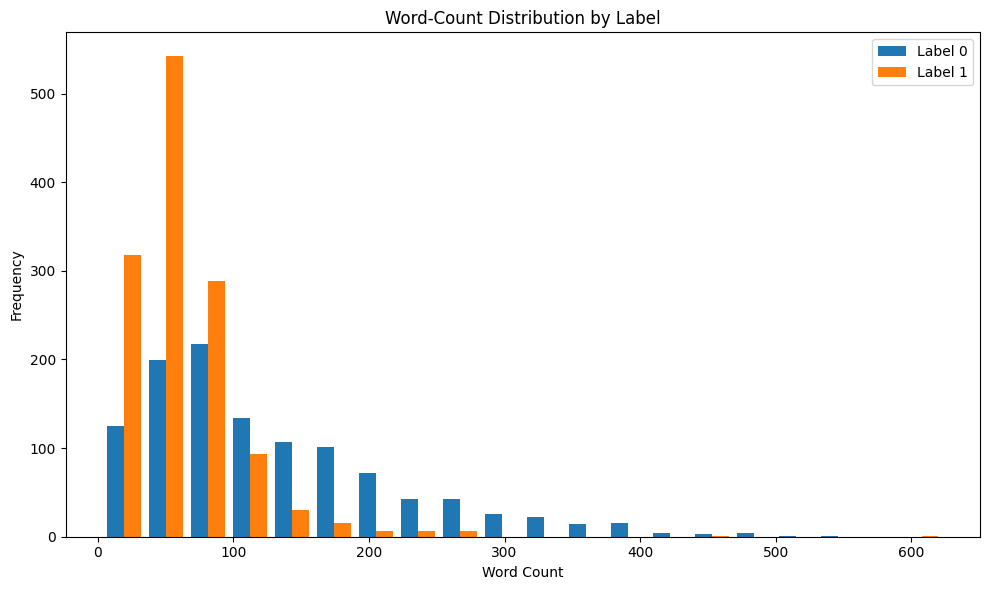

In [36]:
# Plot the distribution of classes

counts_0 = train.loc[train['LABEL'] == 0, 'W_COUNT']
counts_1 = train.loc[train['LABEL'] == 1, 'W_COUNT']

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(
    [counts_0, counts_1],
    bins=20,
    label=['Label 0', 'Label 1']
)

ax.set_title('Word-Count Distribution by Label')
ax.set_xlabel('Word Count')
ax.set_ylabel('Frequency')
ax.legend()
plt.tight_layout()
plt.show()

In [37]:
for lbl in [0, 1]:
    subset = train.loc[train['LABEL'] == lbl, 'W_COUNT']
    print(f"\n\nDescriptive statistics for Trainset where LABEL == {lbl}:")
    print(subset.describe())



Descriptive statistics for Trainset where LABEL == 0:
count    1132.000000
mean      129.256184
std        94.697031
min         4.000000
25%        59.000000
50%       100.000000
75%       179.000000
max       542.000000
Name: W_COUNT, dtype: float64


Descriptive statistics for Trainset where LABEL == 1:
count    1309.000000
mean       60.719633
std        42.020656
min         8.000000
25%        35.000000
50%        52.000000
75%        74.000000
max       623.000000
Name: W_COUNT, dtype: float64


### _This final train dataset is used for fine-tuning the BCBC_